In [44]:
import numpy as np 
import pandas as pd
import os
import matplotlib.image as img
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, Flatten, Conv2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import tensorflow as tf

In [45]:
# Assigning paths to variables
INPUT_PATH = os.path.join('e:/datasets')
DATASET_DIR = os.path.join(INPUT_PATH, 'landmark-recognition-2020')
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, 'train')
TRAIN_LABELMAP_PATH = os.path.join(DATASET_DIR, 'train.csv')

In [46]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'e:/datasets/working/training'
validation_dir = 'e:/datasets/working/validation'
test_dir = 'e:/datasets/working/testing'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size = 16,
    class_mode='categorical',
    seed=42)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size = 16,
    class_mode='categorical',
    seed=42)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size = 1,
    class_mode='categorical',
    seed=42)

Found 12000 images belonging to 100 classes.
Found 4000 images belonging to 100 classes.
Found 4000 images belonging to 100 classes.


In [47]:
MobileNetV2summary = MobileNetV2(include_top=False,
                        weights="imagenet",
                        input_shape=(224, 224, 3)
)

MobileNetV2summary.trainable = True

MobileNetV2summary.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [48]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [51]:
with strategy.scope():
    MobileNetV2Model = MobileNetV2(include_top=False,
                        weights="imagenet",
                        input_shape=(224, 224, 3)
    )

    MobileNetV2Model.trainable = True
    model = Sequential()
    model.add(MobileNetV2Model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='softmax'))
    model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               128100    
Total params: 2,386,084
Trainable params: 2,351,972
Non-trainable params: 34,112
_________________________________________________________________


## Training

In [53]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/25
750/750 [==============================] - 153s 204ms/step - loss: 4.1509 - accuracy: 0.1211 - precision: 1.0000 - recall: 8.3333e-04 - val_loss: 3.4854 - val_accuracy: 0.2128 - val_precision: 0.9636 - val_recall: 0.0132
Epoch 2/25
750/750 [==============================] - 152s 203ms/step - loss: 2.8141 - accuracy: 0.3934 - precision: 0.9792 - recall: 0.0628 - val_loss: 2.3297 - val_accuracy: 0.4493 - val_precision: 0.9404 - val_recall: 0.1577
Epoch 3/25
750/750 [==============================] - 150s 200ms/step - loss: 2.0242 - accuracy: 0.5459 - precision: 0.9649 - recall: 0.2107 - val_loss: 1.6636 - val_accuracy: 0.5987 - val_precision: 0.9168 - val_recall: 0.3498
Epoch 4/25
750/750 [==============================] - 152s 202ms/step - loss: 1.5912 - accuracy: 0.6310 - precision: 0.9524 - recall: 0.3468 - val_loss: 1.3121 - val_accuracy: 0.6712 - val_precision: 0.9094 - val_recall: 0.4893
Epoch 5/25
750/750 [==============================] - 151s 201ms/step - loss: 1.3225

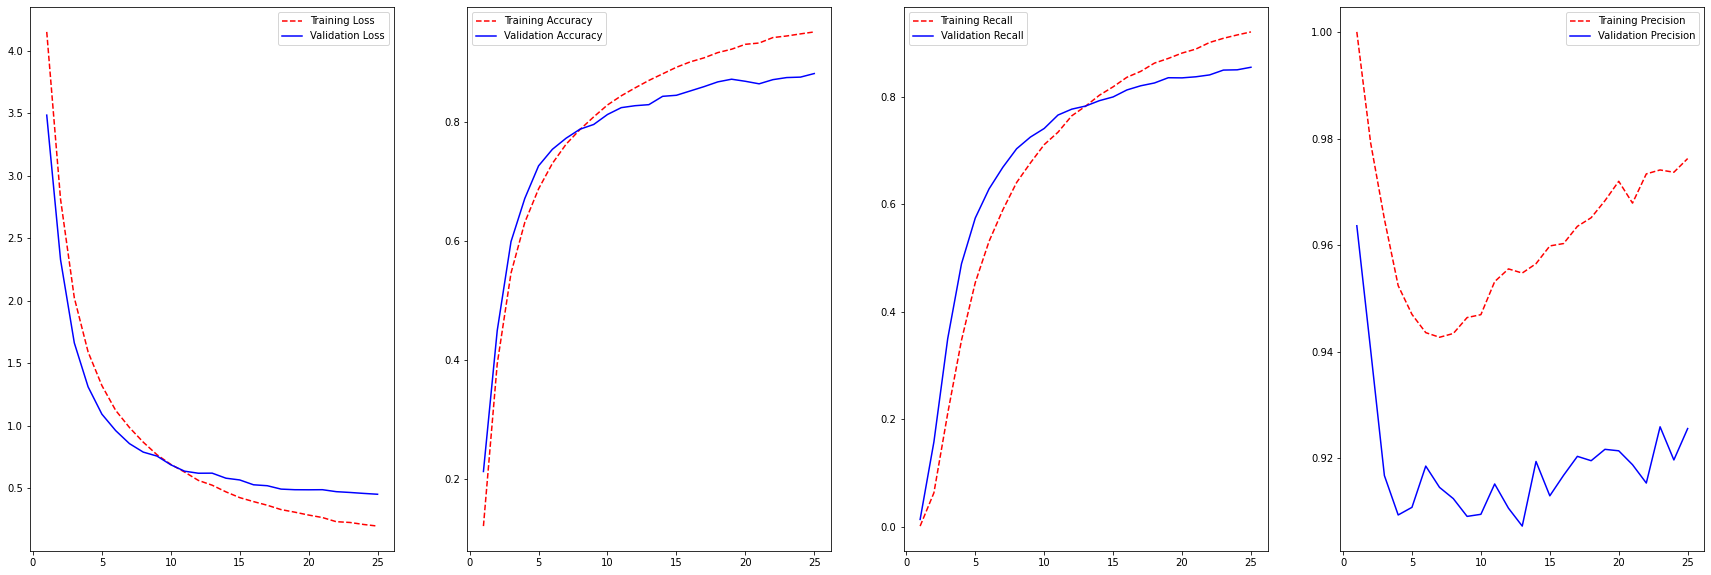

In [59]:


# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [55]:
scores = model.evaluate(test_generator)
print('loss:', scores[0])
print('accuracy:', scores[1])
print('precision:', scores[2])
print('recall:', scores[3])

4000/4000 [==============================] - 52s 13ms/step - loss: 0.4639 - accuracy: 0.8755 - precision: 0.9180 - recall: 0.8562
loss: 0.46386009454727173
accuracy: 0.8755000233650208
precision: 0.9179844260215759
recall: 0.856249988079071


Save model


In [61]:

model.save('mobile_net_v2_25epochs.h5')

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
